In [1]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax import random, jit
from jax.random import PRNGKey

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

import sys
import os
path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

import nn_jax_diffrax

In [4]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [21]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = jnp.array(jnp.squeeze(y_noisy_ho))
t_ho = jnp.array(jnp.squeeze(t_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [12]:
y_pred_results = {}

layer_widths = [2, 64, 64, 2]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

y0 = initial_state

solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    k = int(0.2*N)
    state = node_model.train( state, t_ho[:k] 
                            , y_noisy_ho[:k], y0
                            , num_epochs = 500
                            )
    time_start = time.time()
    k = N
    state = node_model.train( state, t_ho[:k] 
                            , y_noisy_ho[:k], y0
                            , num_epochs = 500
                            )
    time_end = time.time()
    solver_time += time_end - time_start
    
    y_train_pred = node_model.neural_ode(state.params, initial_state, t_ho, state)
    mae_train += np.mean(np.abs(y_ho - y_train_pred))
    
    y_test_pred = node_model.neural_ode(state.params, initial_state, t_test_ho, state)
    mae_test += np.mean(np.abs(y_test_ho - y_test_pred))

Epoch 100, Loss: 4.265145301818848
Epoch 200, Loss: 3.9872727394104004
Epoch 300, Loss: 3.909290313720703
Epoch 400, Loss: 3.841811180114746
Epoch 500, Loss: 3.794768810272217
Epoch 100, Loss: 134.63580322265625
Epoch 200, Loss: 16.765832901000977
Epoch 300, Loss: 16.629993438720703
Epoch 400, Loss: 16.53873062133789
Epoch 500, Loss: 16.60980987548828
Epoch 100, Loss: 3.8087878227233887
Epoch 200, Loss: 3.806931257247925
Epoch 300, Loss: 3.80381178855896
Epoch 400, Loss: 3.8008646965026855
Epoch 500, Loss: 3.798261880874634
Epoch 100, Loss: 16.44367218017578
Epoch 200, Loss: 16.498838424682617
Epoch 300, Loss: 16.355085372924805
Epoch 400, Loss: 16.271100997924805
Epoch 500, Loss: 16.235740661621094
Epoch 100, Loss: 3.8040578365325928
Epoch 200, Loss: 3.8000094890594482
Epoch 300, Loss: 3.7986936569213867
Epoch 400, Loss: 3.7965164184570312
Epoch 500, Loss: 3.7919387817382812
Epoch 100, Loss: 16.223159790039062
Epoch 200, Loss: 16.22165870666504
Epoch 300, Loss: 16.185300827026367
Epoc

In [13]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

Average time elpased: 2.433
Average mae_train: 0.036
Average mae_test: 0.049


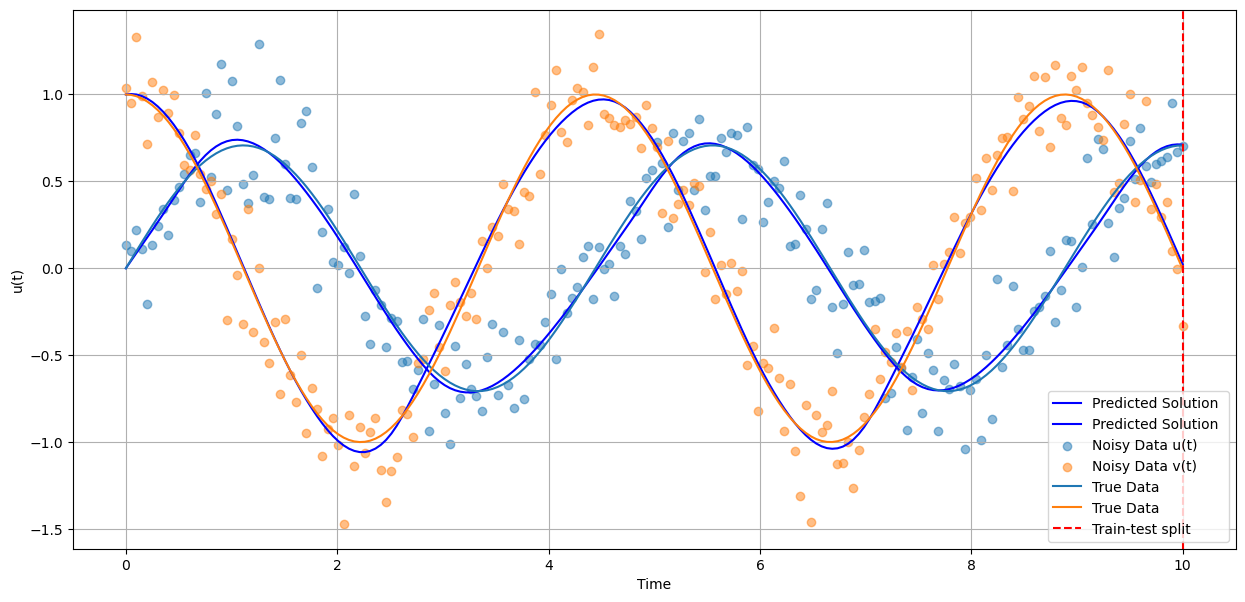

In [14]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_train_pred, 'b', label='Predicted Solution ')
#plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
#plt.plot(t_test_ho, y_test_ho, 'g--', label='True Solution')
#plt.plot(t_test_ho, y_test_pred, 'g--', label='True Solution')

plt.scatter(t_ho, y_noisy_ho.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho, y_noisy_ho.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.plot(t_ho, y_ho, label='True Data', alpha = 1)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---
---


In [2]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)


/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/linear_util.py:192: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/mariiashapo/anaconda3/envs/collocation_env

In [21]:
y_test_vdp.shape

(400, 2)

In [24]:
y_pred_results = {}

layer_widths = [2, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE_JAX(layer_widths=layer_widths, time_invariant=True)
state = neural_ode_model.create_train_state(rng, learning_rate, regularizer = 1e-5)

start_timer = time.time()

for k in [int(len(t_vdp)*0.2), len(t_vdp)]:
    trained_state = neural_ode_model.train(state, t_vdp[:k], y_noisy_vdp[:k], initial_state, num_epochs=20000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_vdp, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]
# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_vdp[N-1:], trained_state)
y_pred_results[1] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_vdp}


Epoch 100, Loss: 0.2184346616268158
Epoch 200, Loss: 0.19413888454437256
Epoch 300, Loss: 0.17216487228870392
Epoch 400, Loss: 0.15223361551761627
Epoch 500, Loss: 0.13904151320457458
Epoch 600, Loss: 0.12711672484874725
Epoch 700, Loss: 0.11744609475135803
Epoch 800, Loss: 0.10943208634853363
Epoch 900, Loss: 0.1026320680975914
Epoch 1000, Loss: 0.09627005457878113
Epoch 1100, Loss: 0.0909845232963562
Epoch 1200, Loss: 0.08627739548683167
Epoch 1300, Loss: 0.08151323348283768
Epoch 1400, Loss: 0.07722824811935425
Epoch 1500, Loss: 0.07318620383739471
Epoch 1600, Loss: 0.06954760104417801
Epoch 1700, Loss: 0.06610971689224243
Epoch 1800, Loss: 0.06292072683572769
Epoch 1900, Loss: 0.060024090111255646
Epoch 2000, Loss: 0.05734642222523689
Epoch 2100, Loss: 0.05489017441868782
Epoch 2200, Loss: 0.052700866013765335
Epoch 2300, Loss: 0.05062348395586014
Epoch 2400, Loss: 0.04879269748926163
Epoch 2500, Loss: 0.04710276797413826
Epoch 2600, Loss: 0.04559731110930443
Epoch 2700, Loss: 0.04

In [25]:
print("MSE on train data: ", np.mean((y_vdp - y_train_pred)**2))
print("MSE on train data: ", np.mean((y_test_vdp[N-1:] - y_test_pred)**2))

MSE on train data:  0.13041385
MSE on train data:  0.45946133


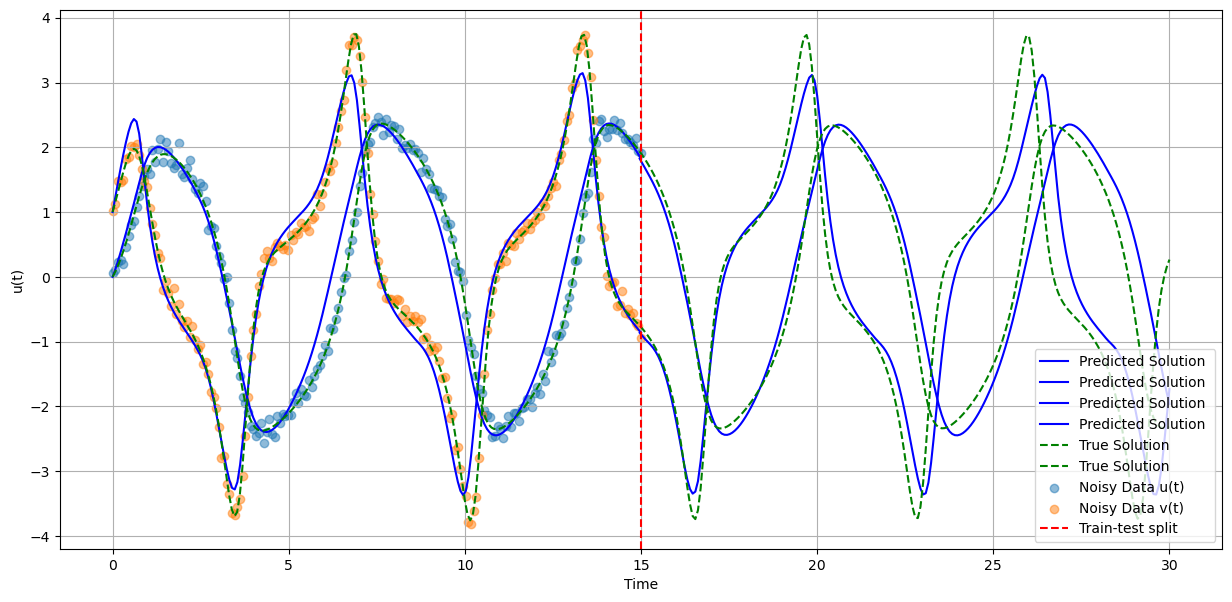

In [26]:
result = y_pred_results[1]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_vdp, result['y_train_pred'], 'b', label='Predicted Solution ')
plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Passing Extra Arguments to the ODE Solver